In [1]:
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
import pims  # image reading routines
import os

import pandas as pd
#from pandas import DataFrame, Series  

import trackpy as tp
from scipy import ndimage  # for shifting images
from pims import pipeline
from pims import Frame
from scipy.interpolate import griddata  # for resampling
import matplotlib.patches as mpatches   # circles
from scipy.signal import savgol_filter
from skimage.transform import rotate


#%load_ext autoreload
#%autoreload 2

#from track_lib import  *

from scipy.optimize import curve_fit
# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)


@pims.pipeline
def gray(image, y0, y1, x0, x1, r, g, b):
    red  = np.array(image[y0:y1, x0:x1, 0])
    redf = red.astype('float')
    green  = np.array(image[y0:y1, x0:x1, 1])
    greenf = green.astype('float')
    blue  = np.array(image[y0:y1, x0:x1, 2])
    bluef = blue.astype('float')

    image = r*redf + g*greenf + b*bluef

    return image

# smooth every image using gaussian filter
from scipy.ndimage import gaussian_filter
@pipeline
def smooth_frame(frame,sigma):
    y= np.array(frame)
    yf = y.astype('float')
    w= gaussian_filter(yf,sigma)
    #i = frame.frame_no
    z= Frame(w)
    #z.frame_no = i  
    return z

#erode image to make processing easier
from scipy.ndimage.morphology import grey_erosion
@pipeline
def erode_frame(frame,sigma):
    y = np.array(frame)
    yf = y.astype('float')
    w = grey_erosion(yf,size=(sigma,sigma))
    #i = frame.frame_no
    z = Frame(w)
    #z.frame_no = i
    return z

#threshold image to make processing easier
@pipeline
def threshold_frame(frame,thresh):
    y = np.array(frame)
    yf = y.astype('float')
    idx = yf[:,:] < thresh
    frame[idx]=0
    #i = frame.frame_no
    z = Frame(frame)
    #z.frame_no = i
    return z

@pims.pipeline
def mask(frame, y0, y1, x0, x1):
    frame[y0:y1,x0:x1] = 0
    z = Frame(frame)
    return z

fps = 4532.87
ascale = 1/162 #cm per pixel
sscale = 1/130

In [4]:
aframesrgb = pims.open('/home/mnei/Desktop/Films/05.16.22/compare7a.mp4')
sframesrgb = pims.open('/home/mnei/Desktop/Films/05.16.22/compare7s.mp4')
aframes = gray(pims.open('/home/mnei/Desktop/Films/05.16.22/compare7a.mp4'), 0, 240, 0, 1280, 0, 1, 0)
sframes = gray(pims.open('/home/mnei/Desktop/Films/05.16.22/compare7s.mp4'), 0, 240, 0, 1280, 0, 1, 0)

Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7fca7d4688b0>
Traceback (most recent call last):
  File "/home/mnei/anaconda3/lib/python3.8/site-packages/pims/pyav_reader.py", line 368, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'
Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7fca7d4688b0>
Traceback (most recent call last):
  File "/home/mnei/anaconda3/lib/python3.8/site-packages/pims/pyav_reader.py", line 368, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'
Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7fca7d4688b0>
Traceback (most recent call last):
  File "/home/mnei/anaconda3/lib/python3.8/site-packages/pims/pyav_reader.py", line 368, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'
Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7fca7d4688b0>
Traceback (most recent cal

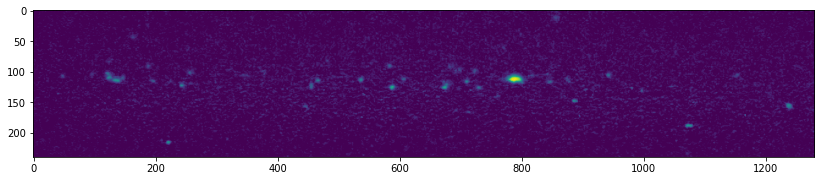

In [6]:
plt.figure(figsize=(14,3))
plt.imshow(sframesrgb[646][0:240,0:1280,1])
f_impact = 646# frame of impact 

In [46]:
msframes = gray(sframesrgb,0,240,0,1200,0, 1, 0) #millet side
mpsframes = smooth_frame(msframes,3.0)# millet processead side
ssframes = gray(sframesrgb,0,240,0,1200,0, 1, 0) #sand side
spsframes = smooth_frame(ssframes,3.0) # sand processed side

maframes = gray(aframesrgb,0,240,900,1200,0, 1, 0) #millet above
mpaframes = erode_frame(smooth_frame(maframes,3.0),21)#millet processed above
saframes = gray(aframesrgb,0,240,0,1200,0, 1, 0) #sand above
spaframes = smooth_frame(saframes,3.0) #sand processed above

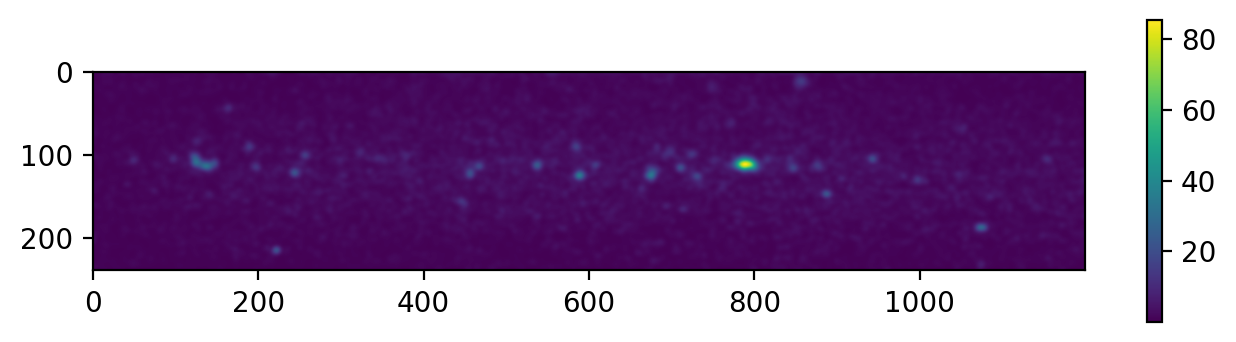

In [35]:
plt.figure(figsize=(8,2),dpi=200); 
plt.imshow(spsframes[600])
plt.colorbar()

In [20]:
@pims.pipeline
def mask(frame, y0, y1, x0, x1):
    frame[y0:y1,x0:x1] = 0
    z = Frame(frame)
    return z

In [52]:
saframes = mask(saframes, 100, 180, 980, 1100)

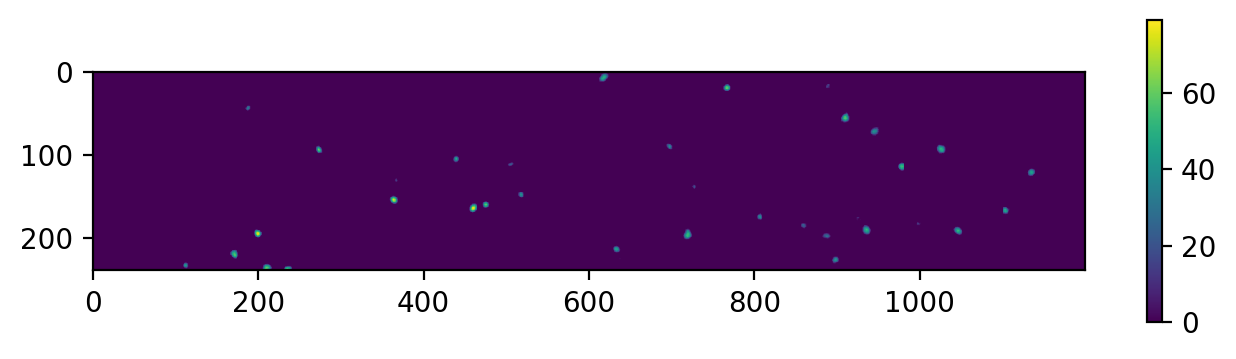

In [141]:
plt.figure(figsize=(8,2),dpi=200); 
plt.imshow(saframes[600])
plt.colorbar()

So, we want to track: sps, mpa, spa

In [36]:
fstart = 600
fend = 1200

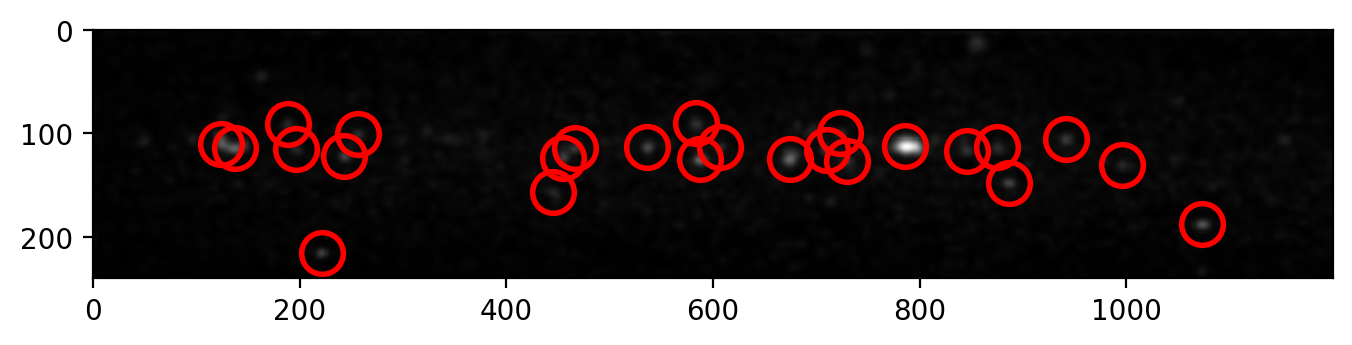

<AxesSubplot:>

In [40]:
plt.figure(figsize=(8,2),dpi=200); 
num = 600
size = 9
thresh = 1
f = tp.locate(spsframes[num], size, invert=False, threshold=thresh)
tp.annotate(f, spsframes[600])

In [41]:
f = tp.batch(spsframes[fstart:fend], size, threshold=thresh, invert=False, processes=1);
t = tp.link(f, 10, memory=10)
tsps = tp.filter_stubs(t, 50) #sand from the side

Frame 599: 15 trajectories present.


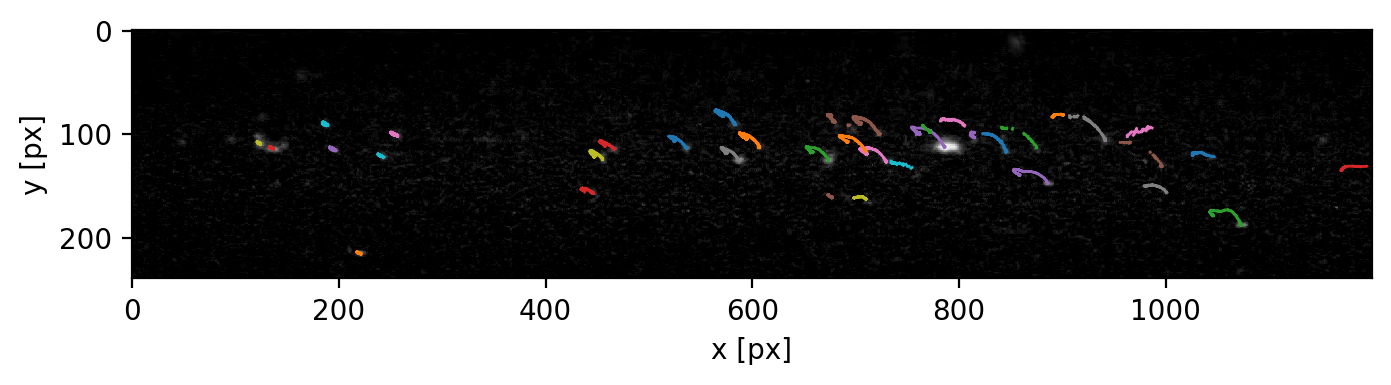

In [42]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tsps, superimpose=ssframes[0], label=False);

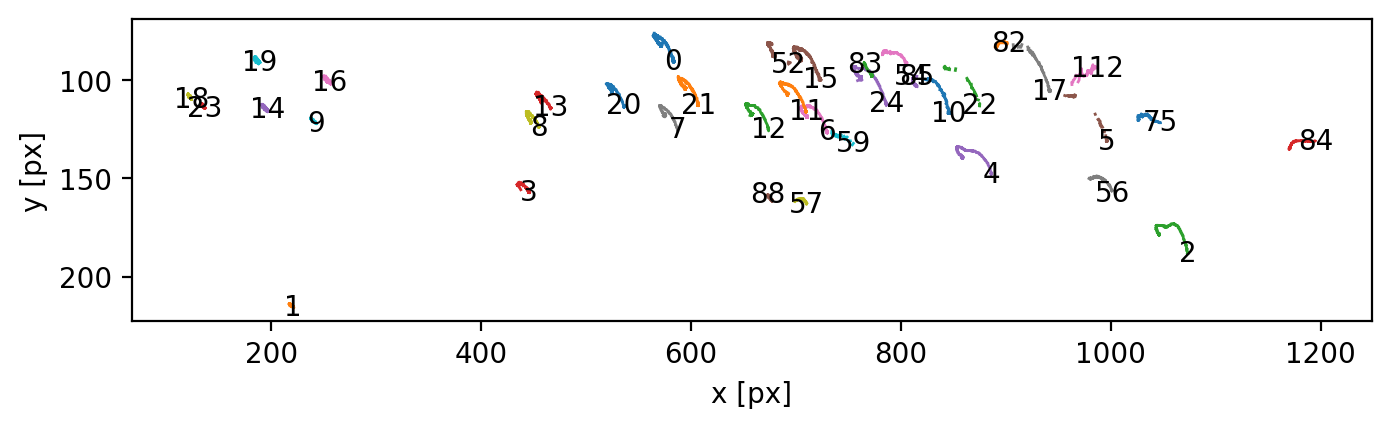

In [43]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tsps, label=True);

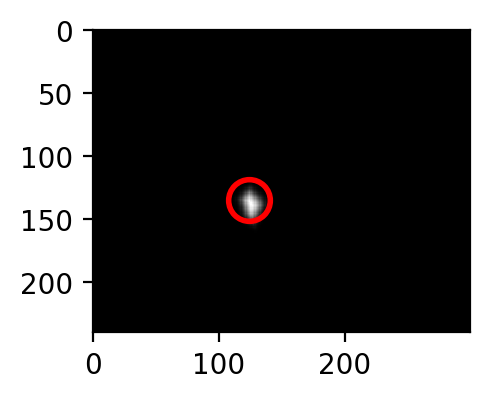

<AxesSubplot:>

In [47]:
plt.figure(figsize=(8,2),dpi=200); 
num = 630
size = 11
thresh = 5
f = tp.locate(mpaframes[num], size, invert=False, threshold=thresh)
tp.annotate(f, mpaframes[630])

In [48]:
f = tp.batch(mpaframes[fstart:fend], size, threshold=thresh, invert=False, processes=1);
t = tp.link(f, 30, memory=30)
tmpa = tp.filter_stubs(t, 50) 

Frame 599: 1 trajectories present.


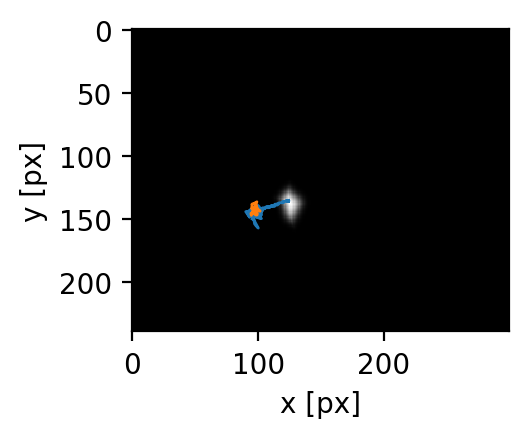

In [50]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tmpa, superimpose=mpaframes[600], label=False);

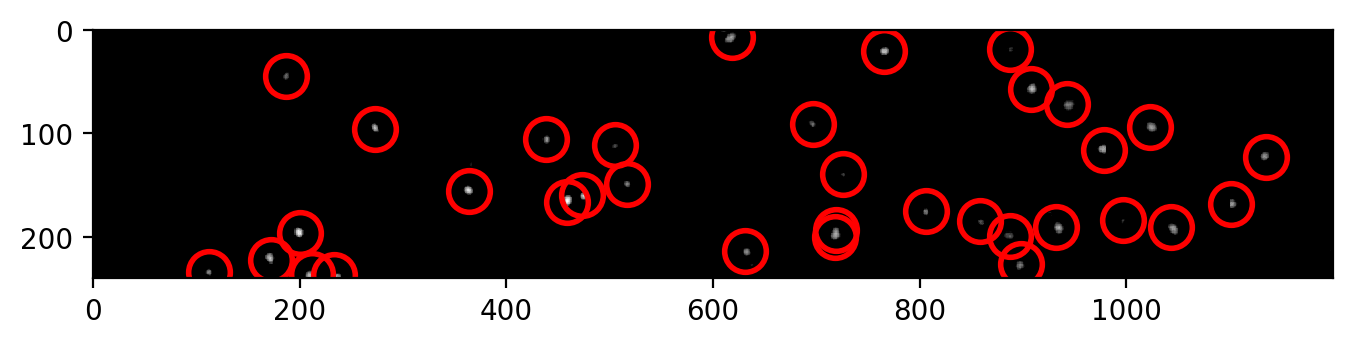

<AxesSubplot:>

In [53]:
plt.figure(figsize=(8,2),dpi=200); 
num = 630
size = 5
thresh = 1
f = tp.locate(saframes[num], size, invert=False)
tp.annotate(f, saframes[630])

In [54]:
f = tp.batch(saframes[fstart:fend], size, invert=False, processes=1);
t = tp.link(f, 10, memory=10)
tsa = tp.filter_stubs(t, 50)

Frame 599: 21 trajectories present.


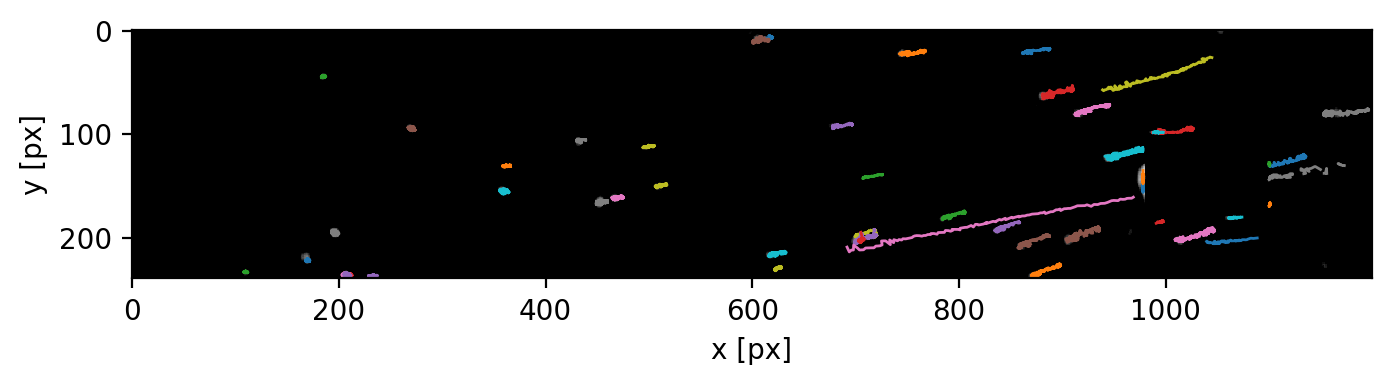

In [55]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tsa, superimpose=saframes[800], label=False);

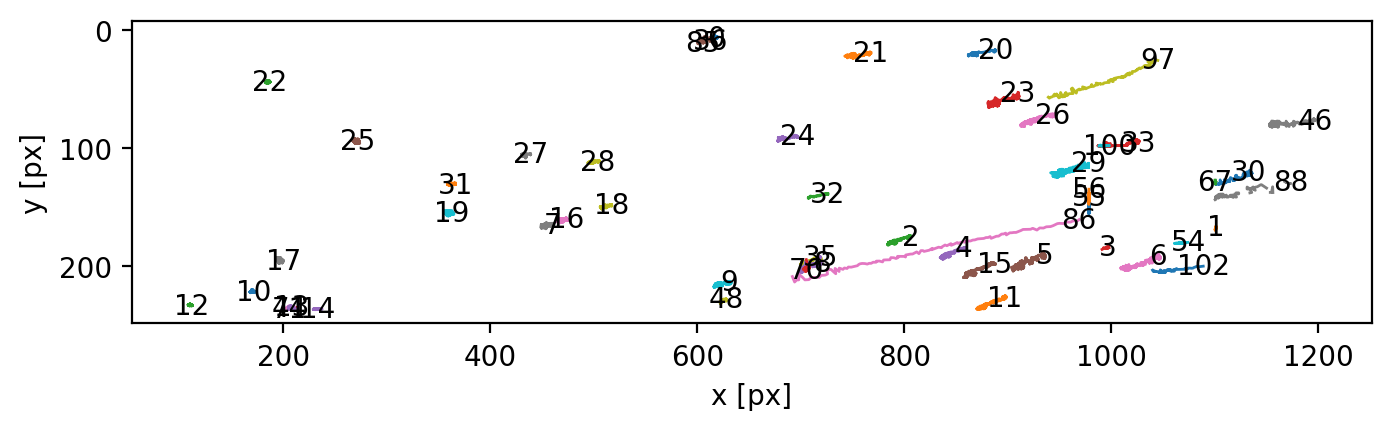

In [95]:
plt.figure(figsize=(8,2),dpi=200);
#plt.figure()
tp.plot_traj(tsa, label=True);

In [56]:
tsps.to_csv('compare7sps'+'.csv', index=True)
tmpa.to_csv('compare7mpa'+'.csv', index=True)
tsa.to_csv('compare7sa'+'.csv', index=True)

In [2]:
s1 = pd.read_csv('compare7sps'+'.csv')

#finds number of particles in dataframe df
def fnumpart(df):
    i=0
    k=0
    while(df.loc[i,"particle"]>=k):
        i+=1
        k=int(df.loc[i-1,"particle"])
    return k+1

snumpart = fnumpart(s1)
frames = 600
sdata = np.zeros((2,snumpart,frames)) #(x or y data, particle number, frame number). Put x in 0 and y in 1.

for i in range(snumpart):
    sdata[0,i,:s1.x[s1.particle==i].size]=np.array(s1.x[s1.particle==i])
    sdata[1,i,:s1.y[s1.particle==i].size]=np.array(s1.y[s1.particle==i])
    
sdata = sdata*sscale

avgend = 50

avgs = np.zeros((2,snumpart))
for i in range(snumpart):#creates average value above array
    avgs[0,i]=np.average(sdata[0, i, :avgend])
    avgs[1,i]=np.average(sdata[1, i, :avgend])
    
shifts = np.empty_like(sdata)
for i in range(snumpart):
    shifts[0,i,:]=sdata[0,i,:]-avgs[0,i]
    shifts[1,i,:]=sdata[1,i,:]-avgs[1,i]
    
#create time axis array
seconds = np.zeros(frames)
for i in range(frames):
    seconds[i] = i*(1/fps)

Text(0.5, 1.0, 'radial displacement of grains from side video')

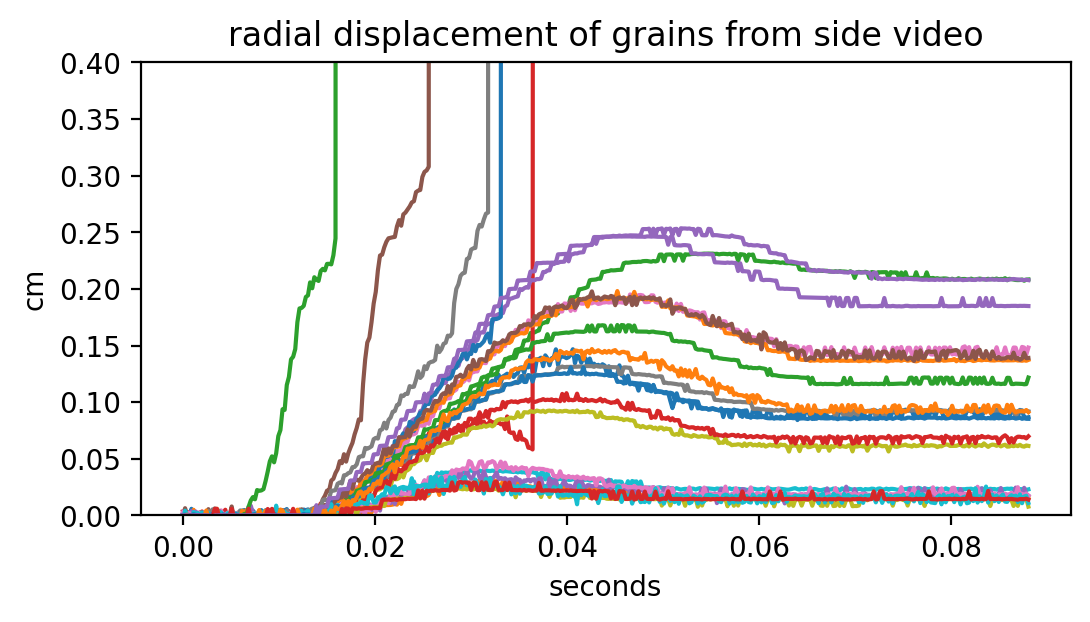

In [3]:
end = 400
plt.figure(figsize=(6,3),dpi=200);
for i in range(snumpart):
    plt.plot(seconds[:end],-1*shifts[0,i,:end])
plt.ylim(0,0.4)
plt.ylabel("cm")
plt.xlabel("seconds")
plt.title("radial displacement of grains from side video")
#24 is the millet grain

Text(0.5, 1.0, 'vertical displacement of grains from side video')

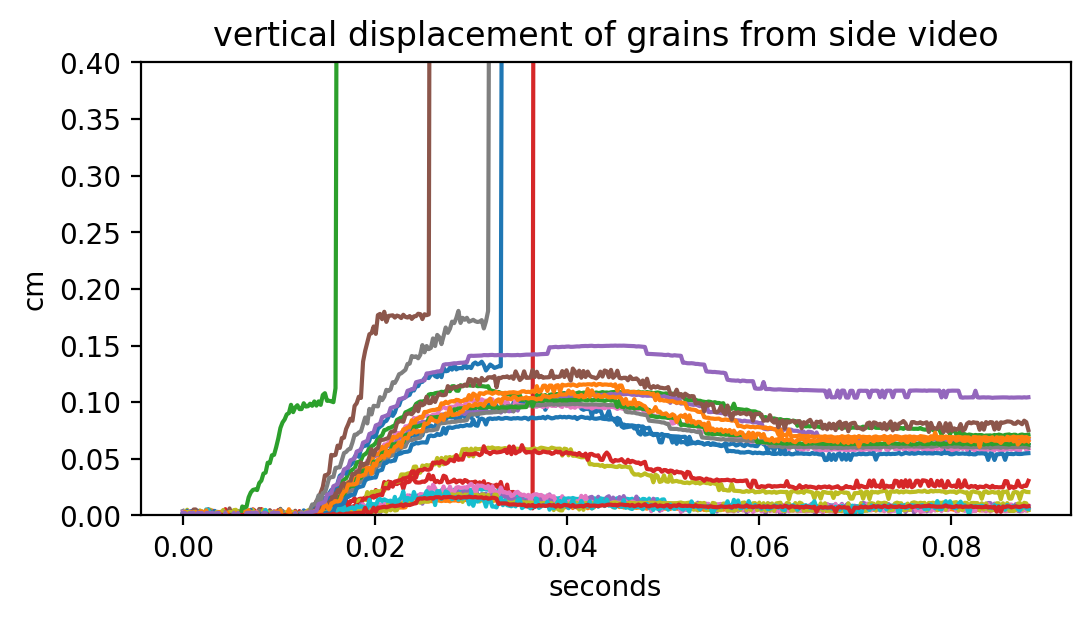

In [4]:
end = 400
plt.figure(figsize=(6,3),dpi=200);
for i in range(snumpart):
    plt.plot(seconds[:end],-1*shifts[1,i,:end])
plt.ylim(0,0.4)
plt.ylabel("cm")
plt.xlabel("seconds")
plt.title("vertical displacement of grains from side video")

In [5]:
accel_xdata = pd.read_csv('compare_7x.csv')
accel_ydata = pd.read_csv('compare_7y.csv')

In [6]:
#Loading accelerometer data from dataframe (need seperate x and y times because it got screwed up)
Timex = np.zeros(accel_xdata.loc[1:,"Time"].size)
Timex[:] = np.array(accel_xdata.loc[1:,"Time"])
Timey = np.zeros(accel_ydata.loc[1:,"Time"].size)
Timey[:] = np.array(accel_ydata.loc[1:,"Time"])
Timex = Timex/1000
Timey = Timey/1000

Accel_xdata = np.zeros((4,accel_xdata.loc[1:,"Time"].size))
Accel_xdata[0,:] = np.array(accel_xdata.loc[1:,"Channel A"])
#Accel_xdata[1,:] = np.array(accel_xdata.loc[1:,"Channel B"])

Accel_ydata = np.zeros((4,accel_ydata.loc[1:,"Time"].size))
Accel_ydata[0,:] = np.array(accel_ydata.loc[1:,"Channel A"])
#Accel_ydata[1,:] = np.array(accel_ydata.loc[1:,"Channel B"])

(0.0, 0.08)

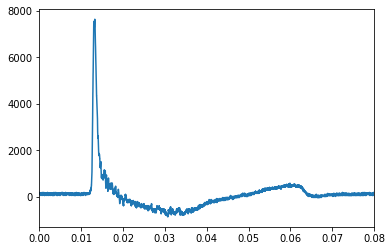

In [7]:
plt.plot(Timex[:]-.13237, (Accel_xdata[0,:]-1.6)*(981/0.06))
#plt.plot(Timex[:]-.13237, Accel_xdata[i,:]-Accel_xdata[i,:]-981*3)
plt.xlim(0, 0.08)

In [8]:
#Acceleration integrator
def find_baseline(channel):
    sum = 0
    for i in range(10000):
        sum += channel[i]
    return sum/10000

conv = 1#981/0.3 #should this be 0.55?

def integrate_accel(channel, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(Time.size-1):
        dv = 0.5*(conv*(channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def sub_integrate_vel(channel, lower, higher, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(lower, higher):
        dv = 0.5*((channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def differentiate(data, f_p_s):
    dx = np.zeros(data.size)
    for i in range(dx.size-1):
        dx[i] = (data[i+1]-data[i])*f_p_s
    return dx

In [9]:
Aaccelx = np.array((Accel_xdata[0,:]-1.6)*(981/0.06))
#Baccelx = np.array((Accel_xdata[1,:]-1.6)*(981/0.06))

Aaccely = np.array((Accel_ydata[0,:]-1.66)*(981/0.06))
#Baccely = np.array((Accel_ydata[1,:]-1.6)*(981/0.06))

Avelx = integrate_accel(Aaccelx, Timex)
#Bvelx = integrate_accel(Baccelx, Timex)

Avely = integrate_accel(Aaccely, Timey)
#Bvely = integrate_accel(Baccely, Timey)

Text(0.5, 0, 'seconds')

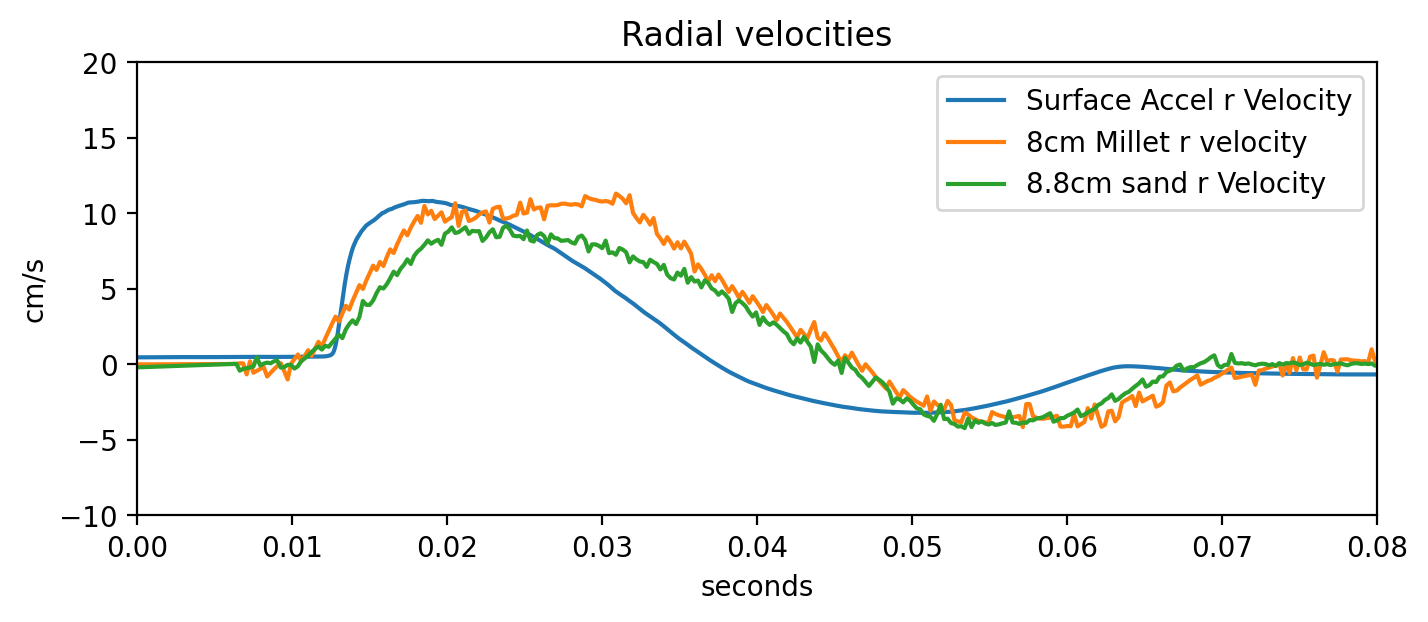

In [10]:
plt.figure(figsize=(8,3),dpi=200); 
plt.plot(Timex[:]-.13237, Avelx[:], label = "Surface Accel r Velocity")
#plt.plot(Timex[:]-.13237, Bvelx[:], label = "Embedded Accel r Velocity")
plt.plot(seconds[:end],-1*differentiate(savgol_filter(shifts[0,24,:end],61,2),fps), label = "8cm Millet r velocity")
plt.plot(seconds[:end],-1*differentiate(savgol_filter(shifts[0,11,:end],61,2),fps), label = "8.8cm sand r Velocity")
plt.xlim(0, 0.08)
plt.ylim(-10, 20)
plt.legend()
plt.title("Radial velocities")
plt.ylabel("cm/s")
plt.xlabel("seconds")

In [11]:
start = 24000
end = 30000
Aposx = sub_integrate_vel(Avelx, start, end, Timex)
#Bposx = sub_integrate_vel(Bvelx, start, 26000, Timex)

Aposy = sub_integrate_vel(Avely, start, end, Timey)
#Bposy = sub_integrate_vel(Bvely, start, 26000, Timey)

Text(0.5, 1.0, 'Radial displacements')

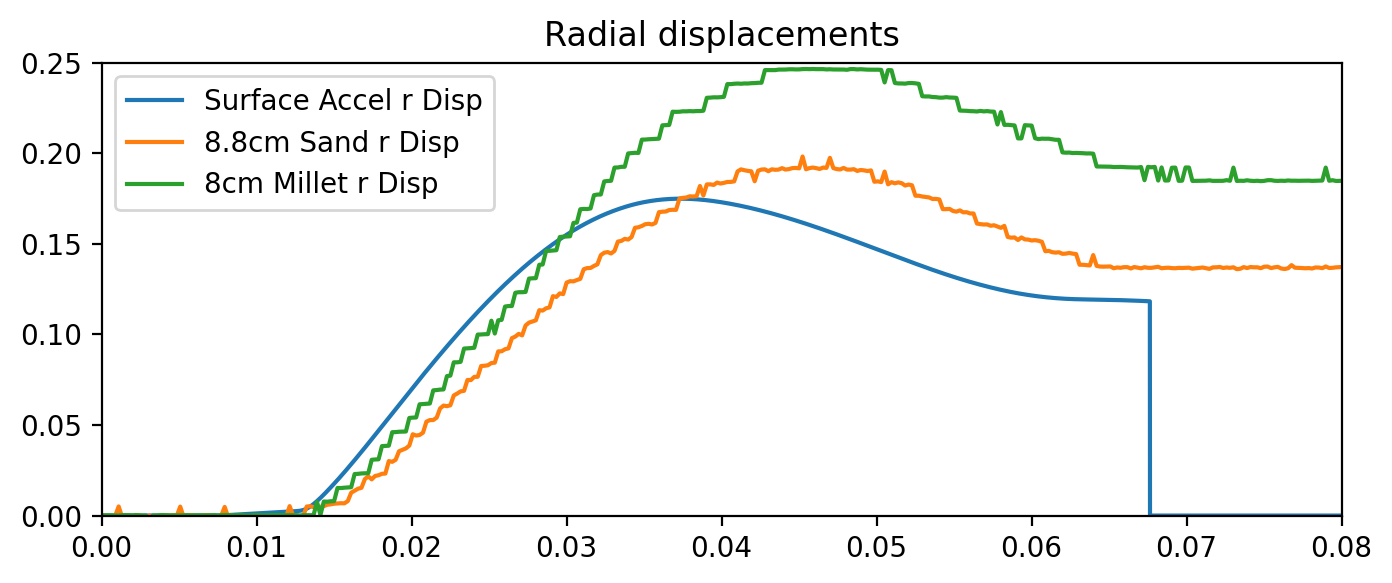

In [12]:
plt.figure(figsize=(8,3),dpi=200); 
plt.plot(Timex[:]-.13237, Aposx[:], label = "Surface Accel r Disp")
#plt.plot(Timex[:]-.13237, Bposx[:], label = "Embedded Accel r Disp")
plt.plot(seconds[:end],-1*shifts[0,11,:end], label = "8.8cm Sand r Disp")
plt.plot(seconds[:end],-1*shifts[0,24,:end], label = "8cm Millet r Disp")
#plt.plot(seconds[:end],-1*savgol_filter(shifts[0,2,:end],61,2), label = "7.9cm Sand r Velocity")
#plt.plot(seconds[:end],-1*savgol_filter(shifts[0,12,:end],61,2), label = "8cm Millet r Velocity")
plt.xlim(0, 0.08)
plt.ylim(0, 0.25)
plt.legend()
plt.title("Radial displacements")

Text(0.5, 1.0, 'Vertical velocities')

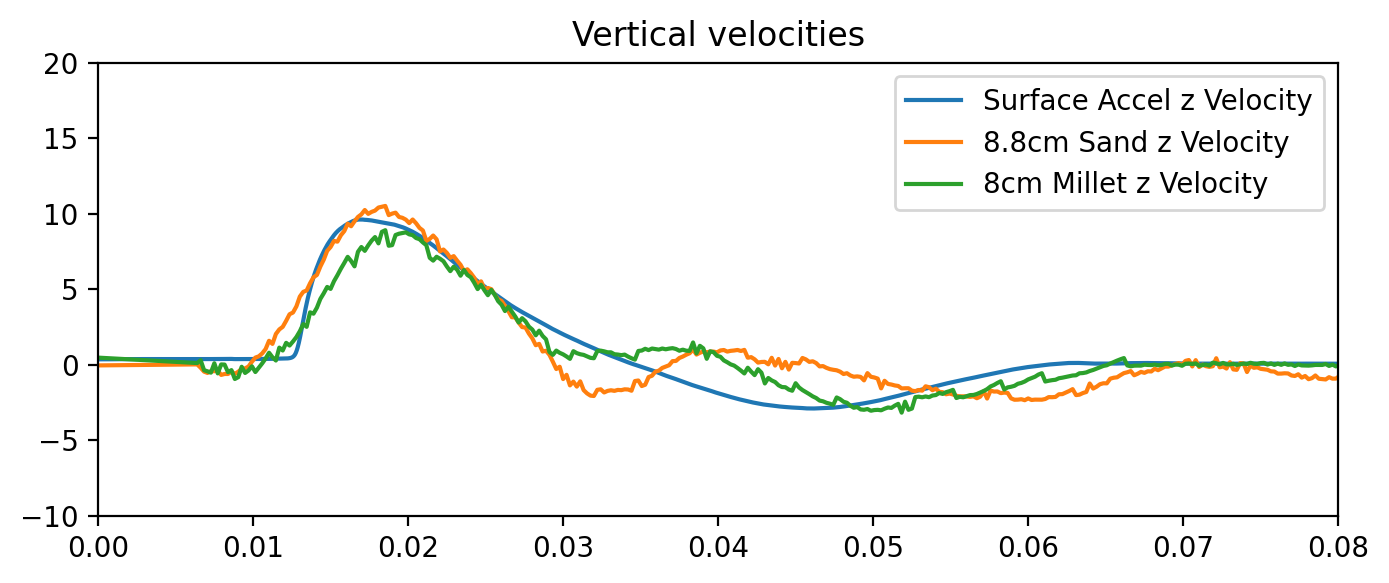

In [13]:
plt.figure(figsize=(8,3),dpi=200); 
plt.plot(Timex[:]-.13237, Avely[:], label = "Surface Accel z Velocity")
#plt.plot(Timex[:]-.13237, Bvely[:], label = "Embedded Accel z Velocity")
plt.plot(seconds[:end],-1*differentiate(savgol_filter(shifts[1,2,:end],61,2),fps), label = "8.8cm Sand z Velocity")
plt.plot(seconds[:end],-1*differentiate(savgol_filter(shifts[1,12,:end],61,2),fps), label = "8cm Millet z Velocity")
#plt.plot(seconds[:end],-1*differentiate(savgol_filter(shifts2[1,20,:end],61,2),fps), label = "8cm Something r Velocity")
plt.xlim(0, 0.08)
plt.ylim(-10, 20)
plt.legend()
plt.title("Vertical velocities")

In [14]:
#checking sand from above, because it tracked well
s2 = pd.read_csv('compare7sa'+'.csv')

#finds number of particles in dataframe df
def fnumpart(df):
    i=0
    k=0
    while(df.loc[i,"particle"]>=k):
        i+=1
        k=int(df.loc[i-1,"particle"])
    return k+1

snumpart2 = fnumpart(s2)
frames = 600
sdata2 = np.zeros((2,snumpart2,frames)) #(x or y data, particle number, frame number). Put x in 0 and y in 1.

for i in range(snumpart2):
    sdata2[0,i,:s2.x[s2.particle==i].size]=np.array(s2.x[s2.particle==i])
    sdata2[1,i,:s2.y[s2.particle==i].size]=np.array(s2.y[s2.particle==i])
    
sdata2 = sdata2*ascale

avgend2 = 50

avgs2 = np.zeros((2,snumpart2))
for i in range(snumpart2):#creates average value above array
    avgs2[0,i]=np.average(sdata2[0, i, :avgend2])
    avgs2[1,i]=np.average(sdata2[1, i, :avgend2])
    
shifts2 = np.empty_like(sdata2)
for i in range(snumpart2):
    shifts2[0,i,:]=sdata2[0,i,:]-avgs2[0,i]
    shifts2[1,i,:]=sdata2[1,i,:]-avgs2[1,i]
    
#create time axis array
seconds = np.zeros(frames)
for i in range(frames):
    seconds[i] = i*(1/fps)

Text(0.5, 1.0, 'radial displacement of sand grains from above video')

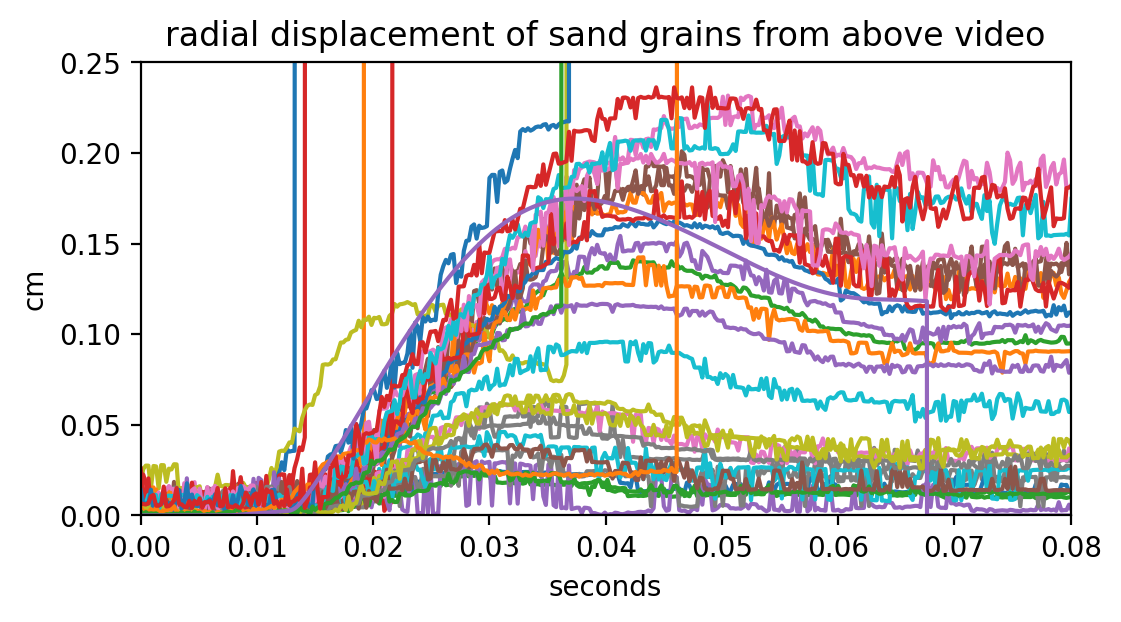

In [15]:
end = 400
plt.figure(figsize=(6,3),dpi=200);
for i in range(snumpart2):
    plt.plot(seconds[:end],(shifts2[0,i,:end]**2+shifts2[1,i,:end]**2)**0.5)
plt.plot(Timex[:]-.13237, Aposx[:], label = "Surface Accel r Disp")
#plt.plot(Timex[:]-.13237, Bposx[:], label = "Embedded Accel r Disp")
plt.ylim(0,0.25)
plt.xlim(0,0.08)
plt.ylabel("cm")
plt.xlabel("seconds")
plt.title("radial displacement of sand grains from above video")

In [16]:
#checking millet from above, because it tracked well
s3 = pd.read_csv('compare7mpa'+'.csv')

snumpart3 = 1 #because there is only 1 millet grain
frames = 600
sdata3 = np.zeros((2,snumpart3,frames)) #(x or y data, particle number, frame number). Put x in 0 and y in 1.

for i in range(snumpart3):
    sdata3[0,i,:s3.x[s3.particle==i].size]=np.array(s3.x[s3.particle==i])
    sdata3[1,i,:s3.y[s3.particle==i].size]=np.array(s3.y[s3.particle==i])
    
sdata3 = sdata3*ascale

avgend3 = 50

avgs3 = np.zeros((2,snumpart3))
for i in range(snumpart3):#creates average value above array
    avgs3[0,i]=np.average(sdata3[0, i, :avgend3])
    avgs3[1,i]=np.average(sdata3[1, i, :avgend3])
    
shifts3 = np.empty_like(sdata3)
for i in range(snumpart3):
    shifts3[0,i,:]=sdata3[0,i,:]-avgs3[0,i]
    shifts3[1,i,:]=sdata3[1,i,:]-avgs3[1,i]
    
#create time axis array
seconds = np.zeros(frames)
for i in range(frames):
    seconds[i] = i*(1/fps)

Text(0.5, 1.0, 'radial displacement of millet grains from above video')

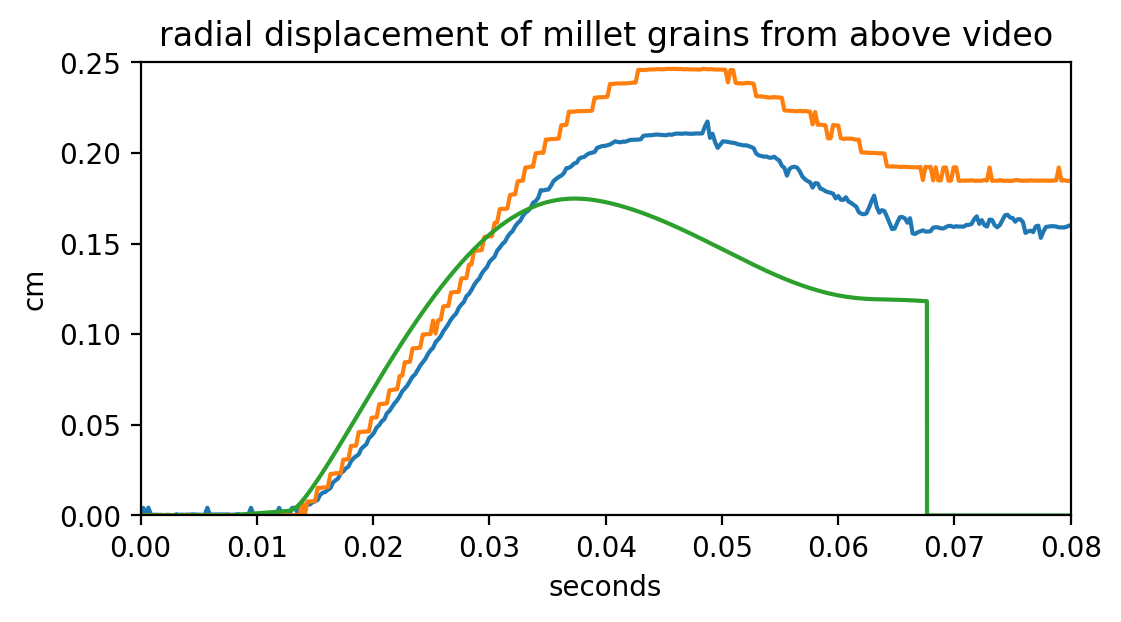

In [17]:
end = 400
plt.figure(figsize=(6,3),dpi=200);
for i in range(snumpart3):
    plt.plot(seconds[:end],(shifts3[0,i,:end]**2+shifts3[1,i,:end]**2)**0.5)
    plt.plot(seconds[:end],-1*shifts[0,24,:end])
plt.plot(Timex[:]-.13237, Aposx[:], label = "Surface Accel r Disp")
#plt.plot(Timex[:]-.13237, Bposx[:], label = "Embedded Accel r Disp")
plt.ylim(0,0.25)
plt.xlim(0,0.08)
plt.ylabel("cm")
plt.xlabel("seconds")
plt.title("radial displacement of millet grains from above video")

above shows curve that is 85% of side video... there is probably a scaling error here.... should check other videos. I am more confident in the above video scale not changing between shots than the side camera.

to do next:
Find end values, peak positions and velocities for each
Combine data from different runs to see if the experiment is consistent enough to fit a model

In [18]:
def last_ind(pulse, thresh):
    grad = abs(differentiate(pulse,fps))
    ind = np.argmax(grad>thresh)
    if(ind == 0):
        ind = 400
    return ind

In [19]:
print(last_ind(Aposx[:], 500))

30000


In [20]:
400/fps

0.08824431320554087

In [21]:
last_points = np.zeros(snumpart)
for i in range(snumpart):
    ind = last_ind(shifts[0,i,:],500)
    last_points[i] = ind
    #print(ind/fps)

want algorithm that takes millet grain initial position and then gives radial distances of all other objects

Text(0.5, 1.0, 'radial displacement of grains from side video')

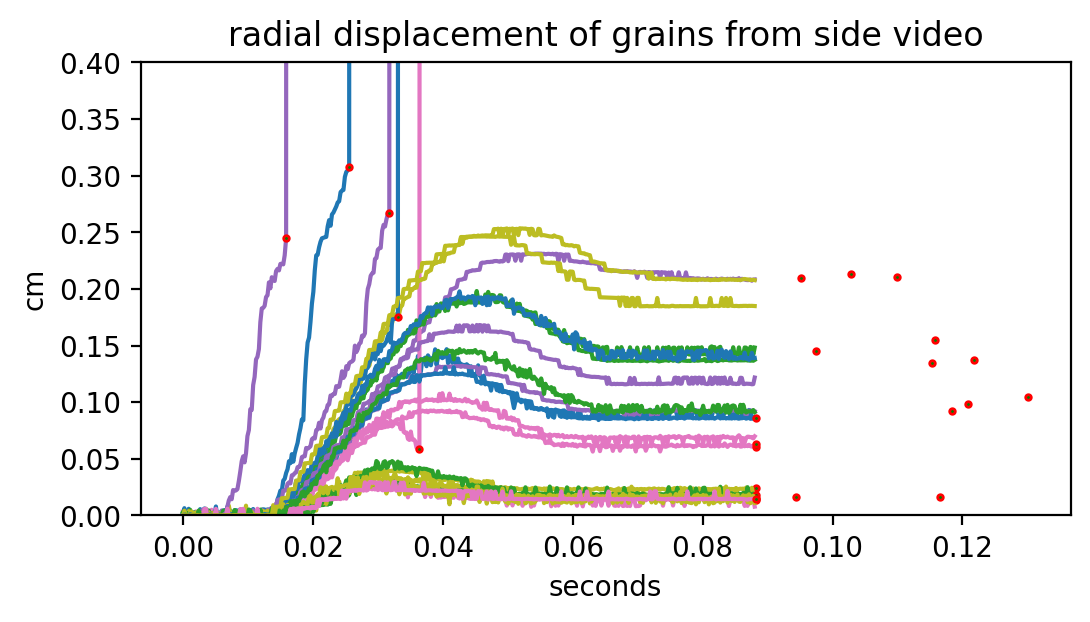

In [22]:
end = 400
plt.figure(figsize=(6,3),dpi=200);
for i in range(snumpart):
    plt.plot(seconds[:end],-1*shifts[0,i,:end])
    plt.plot(last_points[i]/fps, -1*shifts[0,i,int(last_points[i])], marker="o", markersize=2, markeredgecolor="red", markerfacecolor="green")
plt.ylim(0,0.4)
#plt.xlim(0,0.1)
plt.ylabel("cm")
plt.xlabel("seconds")
plt.title("radial displacement of grains from side video")
#24 is the millet grain

In [23]:
def last_ind(pulse, thresh):#500 tends to work well
    grad = abs(differentiate(pulse,fps))
    ind = np.argmax(grad>thresh)
    if(ind == 0):
        ind = 400
    return ind

def peak_pos(pulse, last_ind):
    peak = np.amax(pulse[:last_ind])
    return peak

def final_pos(pulse, last_ind):
    final = pulse[last_ind]
    return final

#in side videos the radial position is just based on the x coordinate, but in above videos it is x and y. We also need the millet grain coordinates, xm and ym

#for the side video:
def rad_s(avg, xm, m_dis):
    dis = (xm + m_dis) - avg 
    return dis

#for the above video:
def rad_a(avgs, xm, ym, m_dis):
    dis = (((xm + m_dis) - avgs[0])**2+(ym-avgs[1])**2)**0.5
    return dis


In [24]:
last_points = np.zeros(snumpart)
for i in range(snumpart):
    ind = last_ind(shifts[0,i,:],500)
    last_points[i] = ind
    #print(ind/fps)

peaks = np.zeros(snumpart)
finals = np.zeros(snumpart)
for i in range(snumpart):
    peaks[i] = peak_pos(-1*shifts[0,i,:], int(last_points[i]))
    finals[i] = final_pos(-1*shifts[0,i,:], int(last_points[i]))
    
#millet position in 7s video is pixel (711, 87)    
srad_pos = np.zeros(snumpart)
for i in range(snumpart):
    srad_pos[i] = rad_s(avgs[0,i], 771*sscale ,8)

In [25]:
last_points2 = np.zeros(snumpart2)
for i in range(snumpart2):
    ind = last_ind(shifts2[0,i,:],500)
    last_points2[i] = ind
    #print(ind/fps)

peaks2 = np.zeros(snumpart2)
finals2 = np.zeros(snumpart2)
for i in range(snumpart2):
    peaks2[i] = peak_pos((shifts2[0,i,:]**2+shifts2[1,i,:]**2)**0.5, int(last_points2[i]))
    finals2[i] = final_pos((shifts2[0,i,:]**2+shifts2[1,i,:]**2)**0.5, int(last_points2[i]))
    
#millet position in 7a video is pixel (1023,163)    
arad_pos = np.zeros(snumpart2)
for i in range(snumpart2):
    arad_pos[i] = rad_a(avgs2[:,i], 1023*ascale, 163*ascale, 8)

Text(0, 0.5, 'total displacement (cm)')

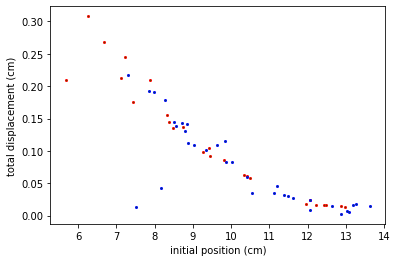

In [26]:
for i in range(snumpart):
    plt.plot(srad_pos[i], finals[i],marker="o", markersize=2, markeredgecolor="red", markerfacecolor="green")
for i in range(snumpart2):
    plt.plot(arad_pos[i], finals2[i],marker="o", markersize=2, markeredgecolor="blue", markerfacecolor="green")
plt.xlabel("initial position (cm)")
plt.ylabel("total displacement (cm)")
#blue is above, red is side

Text(0, 0.5, 'peak displacement (cm)')

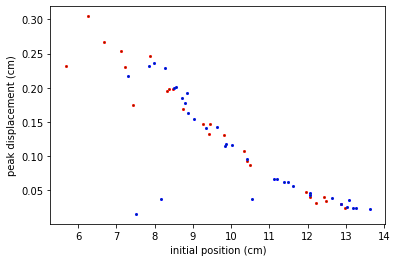

In [27]:
for i in range(snumpart):
    plt.plot(srad_pos[i], peaks[i],marker="o", markersize=2, markeredgecolor="red", markerfacecolor="green", label="peak displacement")
for i in range(snumpart2):
    plt.plot(arad_pos[i], peaks2[i],marker="o", markersize=2, markeredgecolor="blue", markerfacecolor="green", label="peak displacement")
plt.xlabel("initial position (cm)")
plt.ylabel("peak displacement (cm)")

In [28]:
side_vid = np.zeros((snumpart,3))
above_vid = np.zeros((snumpart2,3))

side_vid[:,0] = srad_pos[:]
side_vid[:,1] = finals[:]
side_vid[:,2] = peaks[:]

above_vid[:,0] = arad_pos[:]
above_vid[:,1] = finals2[:]
above_vid[:,2] = peaks2[:]

df = pd.DataFrame(side_vid, columns = ['init_pos','final_pos','peak_pos'])
df2 = pd.DataFrame(above_vid, columns = ['init_pos','final_pos','peak_pos'])

df.to_csv("7s.csv", index = True)
df2.to_csv("7a.csv", index = True)

I have done radial peak and final displacement, now just have to do:
vertical peak & final displacement;
radial peak velocity;
vertical peak velocity.

In [29]:
#vertical position analysis
z_peaks = np.zeros(snumpart)
z_finals = np.zeros(snumpart)

for i in range(snumpart):
    z_peaks[i] = peak_pos(-1*shifts[1,i,:], int(last_points[i]))
    z_finals[i] = final_pos(-1*shifts[1,i,:], int(last_points[i]))
    
z_side_vid = np.zeros((snumpart,3))
z_side_vid[:,0] = srad_pos[:]
z_side_vid[:,1] = z_finals[:]
z_side_vid[:,2] = z_peaks[:]

df3 = pd.DataFrame(z_side_vid, columns = ['init_pos','final_pos','peak_pos'])

df3.to_csv("7sz.csv", index = True) #7 side z-axis

now velocities

In [83]:
#radial velocity analysis
v_peaks = np.zeros(snumpart)
#v_finals = np.zeros(snumpart)
for i in range(snumpart):
    v_peaks[i] = peak_pos(-1*differentiate(savgol_filter(shifts[0,i,:end],61,2),fps), int(last_points[i]))
    #v_finals[i] = final_pos(-1*differentiate(savgol_filter(shifts[0,i,:],61,2)), int(last_points[i]))
    
v_peaks2 = np.zeros(snumpart2)
#v_finals2 = np.zeros(snumpart2)
for i in range(snumpart2):
    v_peaks2[i] = peak_pos(differentiate(savgol_filter((shifts2[0,i,:end]**2+shifts2[1,i,:end]**2)**0.5,61,2),fps), int(last_points2[i]))
    #finals2[i] = final_pos((shifts2[0,i,:]**2+shifts2[1,i,:]**2)**0.5, int(last_points2[i]))

v_side_vid = np.zeros((snumpart,2))
v_above_vid = np.zeros((snumpart2,2))

v_side_vid[:,0] = srad_pos[:]
#v_side_vid[:,1] = v_finals[:]
v_side_vid[:,1] = v_peaks[:]

v_above_vid[:,0] = arad_pos[:]
#above_vid[:,1] = finals2[:]
v_above_vid[:,1] = v_peaks2[:]

df4 = pd.DataFrame(v_side_vid, columns = ['init_pos','peak_vel'])
df5 = pd.DataFrame(v_above_vid, columns = ['init_pos','peak_vel'])

df4.to_csv("7sv.csv", index = True) #side radial velocity
df5.to_csv("7av.csv", index = True) #above radial velocity

In [92]:
#vertical velocity analysis
zv_peaks = np.zeros(snumpart)
#v_finals = np.zeros(snumpart)
for i in range(snumpart):
    zv_peaks[i] = peak_pos(-1*differentiate(savgol_filter(shifts[1,i,:end],61,2),fps), int(last_points[i]))
    #v_finals[i] = final_pos(-1*differentiate(savgol_filter(shifts[0,i,:],61,2)), int(last_points[i]))

zv_side_vid = np.zeros((snumpart,2))

zv_side_vid[:,0] = srad_pos[:]
#v_side_vid[:,1] = v_finals[:]
zv_side_vid[:,1] = zv_peaks[:]

df6 = pd.DataFrame(zv_side_vid, columns = ['init_pos','zpeak_vel'])

df6.to_csv("7svz.csv", index = True) #side velocity z-axis

<ipython-input-94-bae6cde306f9>:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,0.2)


(0.020785452560714946, 0.2)

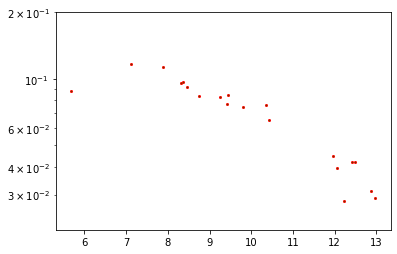

In [94]:
for i in range(snumpart):
    plt.plot(srad_pos[i], v_peaks[i]/100,marker="o", markersize=2, markeredgecolor="red", markerfacecolor="green", label="peak displacement")
plt.yscale('log')
plt.ylim(0,0.2)

(-10.0, 20.0)

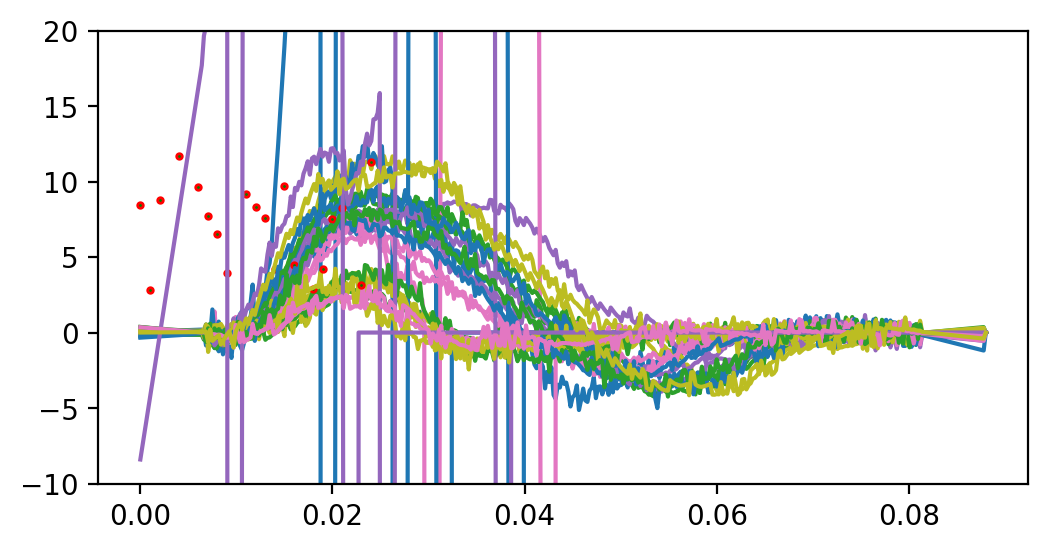

In [89]:
plt.figure(figsize=(6,3),dpi=200);
for i in range(snumpart):
    plt.plot(seconds[:end],-1*differentiate(savgol_filter(shifts[0,i,:end],61,2),fps))
    plt.plot(i*0.001, v_peaks[i], marker="o", markersize=2, markeredgecolor="red", markerfacecolor="green")
plt.ylim(-10,20)

bad: 3, 5, 10, 17, 22